# Muon neutrino interactions SND

We will read a file with neutrino and antineutrinos, already selected into the target (hits have been wrongly written, to be fixed)

In [1]:
import uproot
import awkward #need for flatten or other operations to nested arrays
import numpy as np
import matplotlib.pyplot as plt #for plots

Let us write the functions to read cbmsim branches with uproot

In [2]:
def access_track_branches(simtree, prefix="MCTrack.f", entry_start=0, entry_stop = -1):
 '''reading MCTracks from entry_start to lastentry'''
 if (entry_stop < 0):
        lastentry = simtree.num_entries
 else:
        lastentry = entry_stop
 #what branches do we want to read
 suffixes = ["MotherId","PdgCode","StartX","StartY","StartZ","Px","Py","Pz"]
 branchnames = [prefix + suff for suff in suffixes]
 print(branchnames)
 #reading the branches
 tracks = simtree.arrays(branchnames,entry_start = entry_start, entry_stop = lastentry)
 #returning the produced array
 return tracks

In [3]:
def access_mcpoint_branches(simtree, prefix = "ScifiPoint.f", entry_start=0, entry_stop = -1 ):
 '''reading MCTracks from entry_start to lastentry'''
 if (entry_stop < 0):
        lastentry = simtree.num_entries
 else:
        lastentry = entry_stop   

 suffixes = ["PdgCode","TrackID","X","Y","Z","Px","Py","Pz"]
 branchnames = [prefix + suff for suff in suffixes]
 print(branchnames)
 #reading the branches
 mcpoints = simtree.arrays(branchnames[0:2],entry_start = entry_start, entry_stop = lastentry)
 #adding float interpretation manually
 floatinterpretation = simtree["MCTrack.fStartX"].interpretation
 for name in branchnames[2:]:
  mcpoints[name] = simtree[name].array(floatinterpretation)
 #returning the produced array
 return mcpoints

Let us open the file and getting the TTree

In [4]:
numufile = uproot.open("/eos/user/a/aiulian/sim_snd/numu_sim_activeemu_7_September_2021/inECC_sndLHC.Genie-TGeant4.root")
numutree = numufile["cbmsim"]

In [5]:
antimufile = uproot.open("/eos/user/a/aiulian/sim_snd/anumu_sim_activeemu_8_September_2021/inECC_sndLHC.Genie-TGeant4.root")
antimutree = antimufile["cbmsim"]

Let us retrieve the tracks branch from both files and concatenate them

In [6]:
numutracks = access_track_branches(numutree)
antimu_tracks = access_track_branches(antimutree)
tracks = awkward.concatenate([antimu_tracks,numutracks])

['MCTrack.fMotherId', 'MCTrack.fPdgCode', 'MCTrack.fStartX', 'MCTrack.fStartY', 'MCTrack.fStartZ', 'MCTrack.fPx', 'MCTrack.fPy', 'MCTrack.fPz']
['MCTrack.fMotherId', 'MCTrack.fPdgCode', 'MCTrack.fStartX', 'MCTrack.fStartY', 'MCTrack.fStartZ', 'MCTrack.fPx', 'MCTrack.fPy', 'MCTrack.fPz']


Let us retrieve the tracks coming from the neutrino

In [7]:
neutrinodaughters = tracks["MCTrack.fMotherId"]==0

How do I access track charge?

In [8]:
import ROOT as r


Welcome to JupyROOT 6.24/00


In [9]:
pdgdatabase = r.TDatabasePDG.Instance()

In [10]:
trackpdgs = tracks["MCTrack.fPdgCode"]
nevents = len(trackpdgs)

In [11]:
pdgdatabase.GetParticle(trackpdgs[0,1]).Charge()

3.0

In [12]:
def getcharge(pdgcode):
    charge = 0
    if (pdgdatabase.GetParticle(pdgcode)): #not all particles are known
        charge = pdgdatabase.GetParticle(pdgcode).Charge()
    return charge

In [13]:
test = awkward.to_numpy(awkward.flatten(trackpdgs))

## adding charge
for the moment we do it the old fashioned loop way: slow, to be "vectorized in some way"

In [14]:
trackcharge = []
for event in range(nevents):
    trackchargeevent = []
    for pdgcode in trackpdgs[event]:
        trackchargeevent.append(getcharge(pdgcode))
    trackcharge.append(trackchargeevent)
awtrackcharge = awkward.Array(trackcharge)
tracks["MCTrack.fCharge"] = awtrackcharge

In [15]:
neutrinodaughters = np.logical_and(tracks["MCTrack.fMotherId"]==0,np.abs(tracks["MCTrack.fCharge"]) > 0)

In [16]:
neutrinodaughters_pdgs = trackpdgs[neutrinodaughters]

In [17]:
import matplotlib.pyplot as plt

In [18]:
molteplicity = []
for event in range(nevents):
    molteplicity.append(len(neutrinodaughters_pdgs[event]))

## Plots

we start with the molteplicity plot

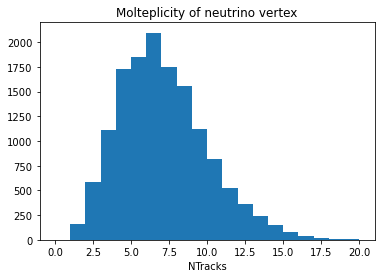

In [19]:
%matplotlib inline
plt.figure()
plt.hist(molteplicity,bins=20,range=[0,20])
plt.xlabel("NTracks")
plt.title("Molteplicity of neutrino vertex")
plt.show()

Neutrino and muon energy plots

In [20]:
tracks["MCTrack.fP"] = np.sqrt(tracks["MCTrack.fPx"] * tracks["MCTrack.fPx"] + tracks["MCTrack.fPy"] * tracks["MCTrack.fPy"] + tracks["MCTrack.fPz"] * tracks["MCTrack.fPz"])

In [21]:
numutracks["MCTrack.fPx"][:,0]

<Array [-0.224, -0.0564, ... -0.0876, -0.0158] type='7405 * float64'>

In [22]:
primarymuon = np.logical_and(tracks["MCTrack.fMotherId"]==0,np.abs(tracks["MCTrack.fPdgCode"]) == 13)

In [23]:
primarymuon_P = tracks["MCTrack.fP"][primarymuon]

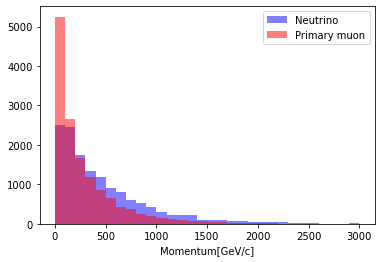

In [24]:
plt.figure()
plt.hist(tracks["MCTrack.fP"][:,0],bins=30,range=[0,3000],color="b",label="Neutrino",alpha=0.5)
plt.hist(awkward.flatten(primarymuon_P),bins=30,range=[0,3000],color="r",label="Primary muon",alpha=0.5)
plt.xlabel("Momentum[GeV/c]")
plt.legend()
plt.show()

In [25]:
primarymuon_P[0]

<Array [460] type='1 * float64'>

In [26]:
len(numutracks)

7405

In [27]:
len(antimu_tracks)

6824

In [28]:
len(tracks)

14229

In **which brick** did the interation happen?

In [29]:
def FindBrick(hitX, hitY, hitZ):
  #associate position to code
  xborder = -27.5 #arbitrary, but accurate enough to separate the bricks
  yborder = 35.1
  if (hitX < xborder):
    nx = 0
  else:
    nx = 1
  if (hitY < yborder):
    ny = 0
  else:
    ny = 1 

  #zborders
  z0_start = -25.4750 
  z0_end = -17.6850
  
  z1_start = -15.8750 
  z1_end = -8.0850
  z2_start = -6.2750  
  z2_end = 1.5150
  z3_start = 3.3250   
  z3_end = 11.1150
  z4_start = 12.9250  
  z4_end = 20.7150
  #condition on z borders
  if (hitZ > z0_start and hitZ < z0_end):
        nz = 0
  elif(hitZ > z1_start and hitZ < z1_end):
    nz = 1
  elif(hitZ > z2_start and hitZ < z2_end):
    nz = 2
  elif(hitZ > z3_start and hitZ < z3_end):
    nz = 3;
  elif(hitZ > z4_start and hitZ < z4_end):
    nz=4
  else:
    nz = -10; #not in a brick

  #return ID
  nbrick = nx + ny*2 + 10 * nz
  return nbrick
 #possible numbers: 0, 1, 2, 3, 10,11,12,13, 20,21,22,23, 30,31,32,33, 40,41,42,43

In [30]:
whichbrick = []
for event in range(nevents):
    vx = tracks["MCTrack.fStartX"][event,0]
    vy = tracks["MCTrack.fStartY"][event,0]
    vz = tracks["MCTrack.fStartZ"][event,0]
    whichbrick.append(FindBrick(vx,vy,vz))

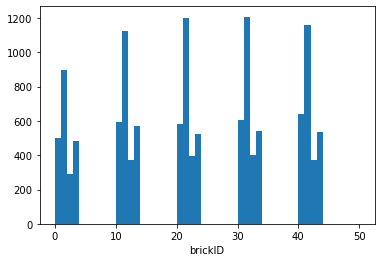

In [31]:
plt.figure()
plt.hist(whichbrick,bins=50,range=[0,50])
plt.xlabel("brickID")
plt.show()

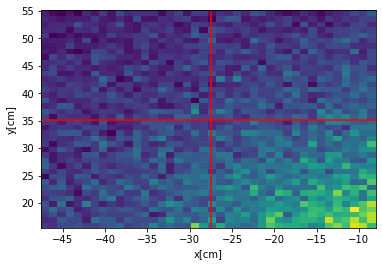

In [38]:
plt.figure()
plt.hist2d(awkward.to_numpy(tracks["MCTrack.fStartX"][:,0]),awkward.to_numpy(tracks["MCTrack.fStartY"][:,0]),bins=[40,40],range=[[-47.6 , -8.0 ],[15.5 , 55.1 ]])
plt.xlabel("x[cm]")
plt.ylabel("y[cm]")
plt.plot([-27.5,-27.5],[15,55],"r")
plt.plot([-50,-5],[35.1,35.1],"r")
plt.show()

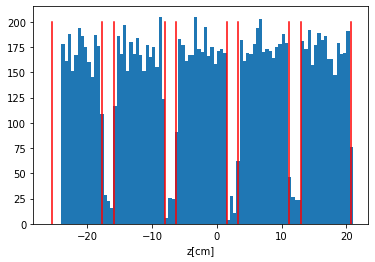

In [43]:
plt.figure()
plt.hist(awkward.to_numpy(tracks["MCTrack.fStartZ"][:,0]),bins=94,range=[-26.,21.])
plt.xlabel("z[cm]")

#adding lines
plt.plot([-25.4750 , -25.4750],[0,200],"r")
plt.plot([-17.6850 , -17.6850],[0,200],"r")

plt.plot([ -15.8750 ,-15.8750],[0,200],"r")
plt.plot([-8.0850,-8.0850],[0,200],"r")

plt.plot([-6.2750  ,-6.2750],[0,200],"r")
plt.plot([1.5150  ,1.5150],[0,200],"r")

plt.plot([3.3250   ,3.3250],[0,200],"r")
plt.plot([11.1150  ,11.1150],[0,200],"r")

plt.plot([12.9250,12.9250],[0,200],"r")
plt.plot([20.7150,20.7150],[0,200],"r")

plt.show()